In [1]:
import seaborn as sns
import pandas as pd

# Load dataset
df = sns.load_dataset('titanic')
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [2]:
df.shape

(891, 15)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [5]:
df.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Select useful columns
cols = ['survived', 'pclass', 'sex', 'age', 'fare', 'embarked']
data = df[cols].dropna()  # drop rows with missing data

# Encode categorical variables
data['sex'] = data['sex'].map({'male': 0, 'female': 1})
data = pd.get_dummies(data, columns=['embarked'], drop_first=True)

# Split features and label
X = data.drop('survived', axis=1)
y = data['survived']


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)


In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.6869158878504673
              precision    recall  f1-score   support

           0       0.72      0.75      0.73       122
           1       0.64      0.61      0.63        92

    accuracy                           0.69       214
   macro avg       0.68      0.68      0.68       214
weighted avg       0.69      0.69      0.69       214



In [9]:
# Get cost-complexity pruning path
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Train different trees for each alpha
clfs = []
for alpha in ccp_alphas:
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha)
    tree.fit(X_train, y_train)
    clfs.append(tree)

# Evaluate each model
train_scores = [tree.score(X_train, y_train) for tree in clfs]
test_scores = [tree.score(X_test, y_test) for tree in clfs]


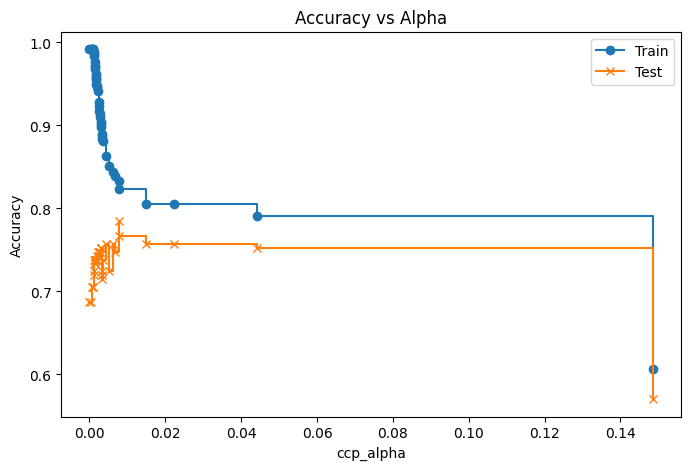

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(ccp_alphas, train_scores, marker='o', label='Train', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='x', label='Test', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Alpha")
plt.legend()
plt.show()


In [11]:
import numpy as np

best_index = np.argmax(test_scores)
best_alpha = ccp_alphas[best_index]
best_tree = clfs[best_index]

print("Best alpha:", best_alpha)
print("Best test accuracy:", test_scores[best_index])


Best alpha: 0.0077064852148304025
Best test accuracy: 0.7850467289719626


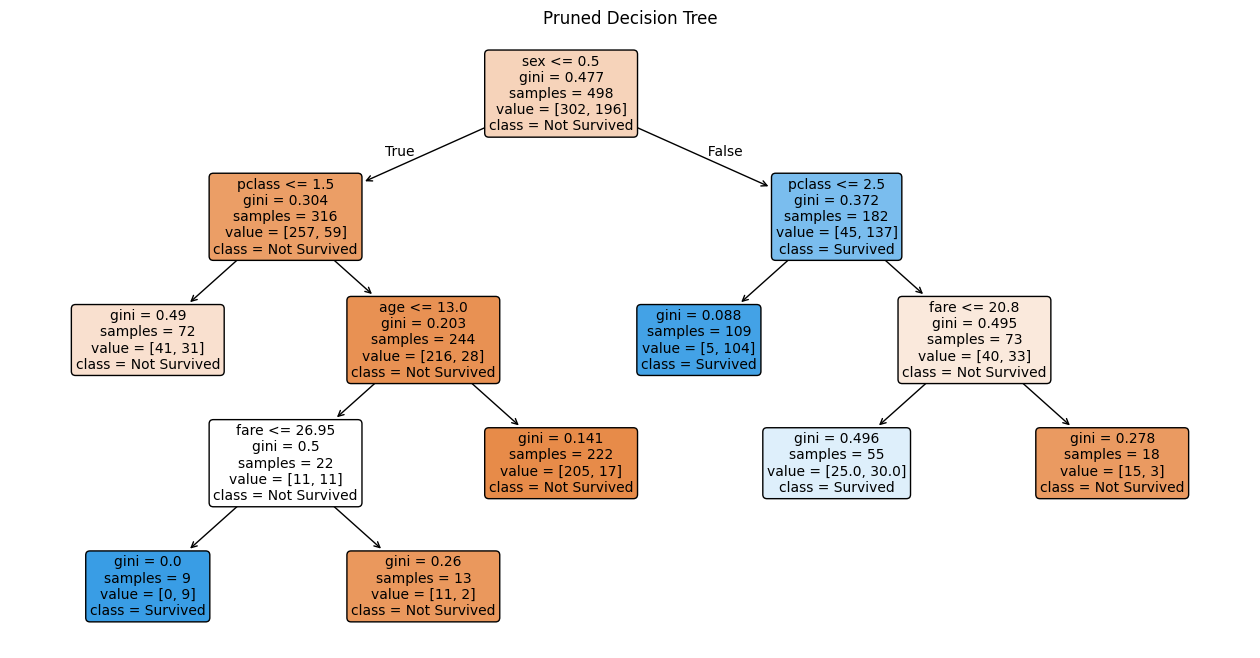

In [12]:
from sklearn.tree import plot_tree

plt.figure(figsize=(16, 8))
plot_tree(best_tree, 
          filled=True, 
          feature_names=X.columns, 
          class_names=['Not Survived', 'Survived'], 
          rounded=True,
          fontsize=10)
plt.title("Pruned Decision Tree")
plt.show()
